In [35]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

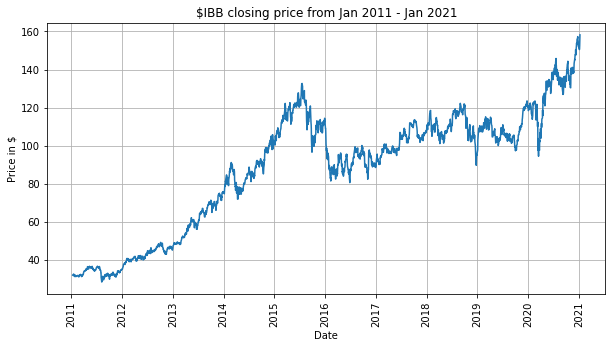

In [12]:
def parser(x):
    return datetime.strptime(x, "%Y-%m-%d")


data = pd.read_csv('IBB.csv', usecols=[0,4], parse_dates=[0], header=0, date_parser=parser)
plt.figure(figsize=[10, 5]); # Set dimensions for figure
plt.plot(data['Date'], data['Close'])
plt.title('$IBB closing price from Jan 2011 - Jan 2021')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

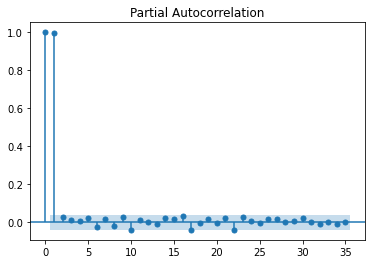

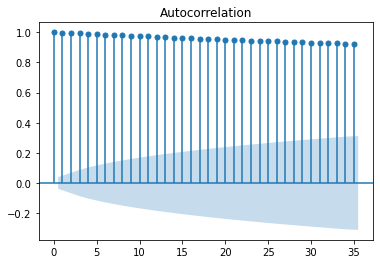

In [13]:
plot_pacf(data['Close'])
plot_acf(data['Close'])
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['Close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.6200961337045798
p-value: 0.8663761624686823


In [40]:
# Take the log difference to make data stationary

data['Close'] = np.log(data['Close'])
data['Close'] = data['Close'].diff()
data = data.drop(data.index[0])
data.head()

,Date,Close
2511,2021-01-04,NaN
2512,2021-01-05,NaN
2513,2021-01-06,1.768441
2514,2021-01-07,0.909361
2515,2021-01-08,-1.593525


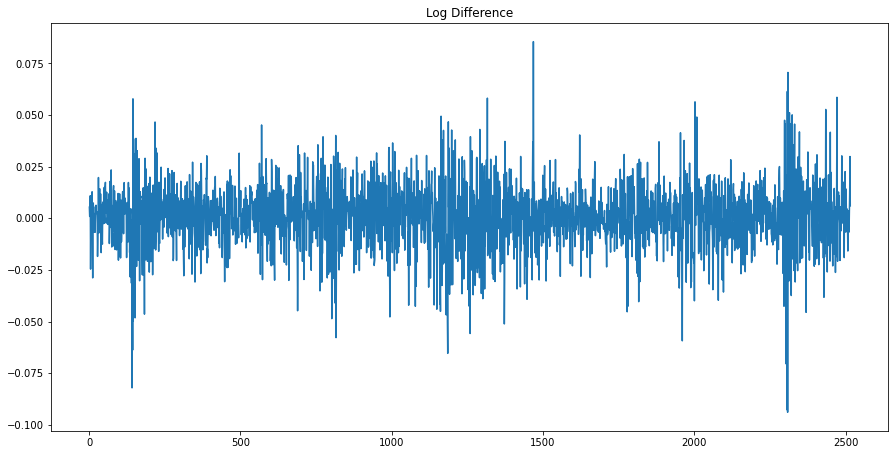

In [16]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['Close'])
plt.title("Log Difference")
plt.show()

In [17]:
# Augmented Dickey-Fuller test for log

ad_fuller_result = adfuller(data['Close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -18.589536471610753
p-value: 2.074127275853548e-30


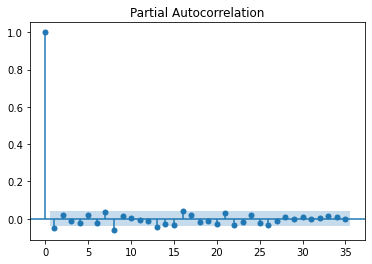

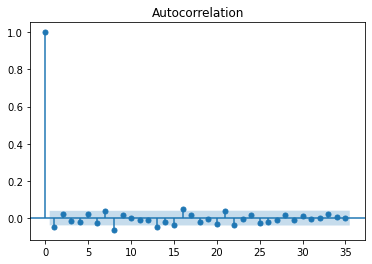

In [18]:
plot_pacf(data['Close'])
plot_acf(data['Close'])
plt.show()

In [23]:
#Split test and train dataset
train_data, test_data = train_test_split(data['Close'], test_size=0.33, shuffle = False, stratify = None)

ARIMA_model = ARIMA(train_data, order=(2,1,3)).fit()
print(ARIMA_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1684
Model:                 ARIMA(2, 1, 3)   Log Likelihood                4631.431
Method:                       css-mle   S.D. of innovations              0.015
Date:                Thu, 28 Jan 2021   AIC                          -9248.863
Time:                        13:52:49   BIC                          -9210.860
Sample:                             1   HQIC                         -9234.787
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.192e-07   7.81e-07     -0.793      0.428   -2.15e-06    9.12e-07
ar.L1.D.Close    -1.7140      0.017    -98.822      0.000      -1.748      -1.680
ar.L2.D.Close    -0.9120        nan     

In [20]:
# Ljung-Box test
ljung_box, p_value = acorr_ljungbox(ARIMA_model.resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [ 0.39513526  0.70205348  1.93248901  4.9684392   6.57728798  7.27804038
  7.47957974  7.49959933 11.18762573 13.36886031]
p-value: [0.52961237 0.70396493 0.58653641 0.29055119 0.25402282 0.29589785
 0.38070782 0.48380879 0.26306714 0.20377324]


In [21]:
forecast = ARIMA_model.forecast()

print(forecast)

1685    0.000522
dtype: float64


In [39]:
def run_forecast ():
    predictions = list()
    all_values = [x for x in train_data]
    
    # walk-forward validation
    for t in range(len(test_data)):
        temp_model = ARIMA(all_values, order=(2,1,3)).fit()
        output = temp_model.forecast()
        output_value = output[0]
        predictions.append(output_value)
        prediction_value = test_data[t]
        all_values.append(prediction_value)
        predictions.append(output[0])
        all_values.append(test_data[t])
        print('predicted=%f, expected=%f' % (output_value, prediction_value))
        return predictions

pred = run_forecast()    
    


KeyError: 0

In [38]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test_data)
pyplot.plot(predictions, color='red')
pyplot.show()

ValueError: Found input variables with inconsistent numbers of samples: [830, 1]

KeyError: 0